In [29]:
import re
import pandas as pd
import seaborn as sns
import yfinance as yf
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline

### Parameters

In [40]:
# Time frame

### Dataset


#### Sentiment dataset

In [46]:
# merge the datasets
ge_openai_gpt35_headlines_df = pd.read_csv('../data/GE_OpenAI-GPT3.5_headlines.csv', dtype={'Sentiment': float, 'Stock_symbol': str, 'Url': str}, parse_dates=['Date']).drop(['Stock_symbol', 'Url'], axis=1).set_index(['Date']).rename(columns={"Sentiment": "GPT3.5"})
ge_finbert_headlines_df = pd.read_csv('../data/GE_ProsusAI_finBERT_headlines.csv', dtype={'Sentiment': float, 'Stock_symbol': str, 'Url': str}, parse_dates=['Date']).drop(['Stock_symbol', 'Url'], axis=1).set_index(['Date']).rename(columns={"Sentiment": "FinBERT"})
ge_llama2_13b_gguf_fullarticle_df = pd.read_csv('../data/GE_TheBloka_Llama-2-13b_Q4_K_M_gguf_fullarticles.csv', dtype={'Sentiment': float, 'Stock_symbol': str, 'Url': str}, parse_dates=['Date']).drop(['Stock_symbol', 'Url'], axis=1).set_index(['Date']).rename(columns={"Sentiment": "Llama2-13b-GGUF"})
ge_llama2_13b_gptq_fullarticle_df = pd.read_csv('../data/GE_TheBloke_Llama-2-13B-GPTQ_fullarticles.csv', dtype={'Sentiment': float, 'Stock_symbol': str, 'Url': str}, parse_dates=['Date']).drop(['Stock_symbol', 'Url'], axis=1).set_index(['Date']).rename(columns={"Sentiment": "Llama2-13b-GPTQ"})
ge_llama2_70b_gptq_fullarticle_df = pd.read_csv('../data/GE_TheBloke_Llama-2-70B-GPTQ_fullarticles.csv', dtype={'Sentiment': float, 'Stock_symbol': str, 'Url': str}, parse_dates=['Date']).drop(['Stock_symbol', 'Url'], axis=1).set_index(['Date']).rename(columns={"Sentiment": "Llama2-70b-GPTQ"})
ge_llama3_70b_gptq_fullarticle_df = pd.read_csv('../data/GE_TechxGenus_Llama-3-70B-Instruct-GPTQ.csv', dtype={'Sentiment': float, 'Stock_symbol': str, 'Url': str}, parse_dates=['Date']).drop(['Stock_symbol', 'Url'], axis=1).set_index(['Date']).rename(columns={"Sentiment": "Llama3-70b-GPTQ"})

merged_df = pd.concat([ge_openai_gpt35_headlines_df, ge_finbert_headlines_df, ge_llama2_13b_gguf_fullarticle_df, ge_llama2_13b_gptq_fullarticle_df, ge_llama2_70b_gptq_fullarticle_df, ge_llama3_70b_gptq_fullarticle_df], axis=1)
merged_df

,GPT3.5,FinBERT,Llama2-13b-GGUF,Llama2-13b-GPTQ,Llama2-70b-GPTQ,Llama3-70b-GPTQ
Date,,,,,,
2023-12-16 21:00:00+00:00,4.0,4.856880,4.0,2.0,4.0,4.0
2023-12-16 00:00:00+00:00,5.0,4.722641,4.0,4.0,4.0,5.0
2023-12-16 00:00:00+00:00,3.0,3.151579,4.0,4.0,4.0,4.0
2023-12-16 00:00:00+00:00,4.0,4.663424,4.0,3.0,2.0,4.0
2023-12-15 00:00:00+00:00,3.0,2.593138,4.0,3.0,4.0,4.0
...,...,...,...,...,...,...
2012-04-23 00:00:00+00:00,5.0,3.744149,3.0,3.0,4.0,4.0
2012-04-23 00:00:00+00:00,3.0,2.466803,4.0,4.0,3.0,4.0
2012-04-20 00:00:00+00:00,4.0,3.857823,4.0,4.0,4.0,5.0


There are no missing values

In [119]:
merged_df.isna().sum()

GPT3.5             0
FinBERT            0
Llama2-13b-GGUF    0
Llama2-13b-GPTQ    0
Llama2-70b-GPTQ    0
Llama3-70b-GPTQ    0
Time               0
dtype: int64

Compare mean and range of values among the results

In [121]:
merged_df.describe()

,GPT3.5,FinBERT,Llama2-13b-GGUF,Llama2-13b-GPTQ,Llama2-70b-GPTQ,Llama3-70b-GPTQ
count,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000,8680.000000
mean,3.331452,2.614096,3.308525,3.181452,2.999654,3.268203
std,1.053660,1.147998,0.721964,0.709361,1.040542,1.217533
min,1.000000,0.078855,0.000000,1.000000,0.000000,0.000000
25%,3.000000,2.445793,3.000000,3.000000,3.000000,2.000000
50%,3.000000,2.560233,3.000000,3.000000,3.000000,4.000000
75%,4.000000,2.954813,4.000000,4.000000,4.000000,4.000000
max,5.000000,4.857064,7.000000,7.000000,7.000000,5.000000


Check value distribution

In [124]:
for column in merged_df.columns: #[:-1]
    print(merged_df[column].value_counts())

GPT3.5
3.0    3089
4.0    2813
5.0    1127
2.0    1112
1.0     539
Name: count, dtype: int64
FinBERT
2.491283    31
2.591554    24
2.367193    19
2.593138    16
2.648294    16
            ..
2.534693     1
2.522934     1
2.982258     1
2.488833     1
2.524730     1
Name: count, Length: 8105, dtype: int64
Llama2-13b-GGUF
4.0    3996
3.0    3367
2.0    1312
1.0       2
0.0       2
7.0       1
Name: count, dtype: int64
Llama2-13b-GPTQ
3.0    4402
4.0    2948
2.0    1209
1.0     102
5.0      18
7.0       1
Name: count, dtype: int64
Llama2-70b-GPTQ
3.0    3383
4.0    2998
1.0    1182
2.0     948
5.0     161
0.0       6
7.0       1
6.0       1
Name: count, dtype: int64
Llama3-70b-GPTQ
4.0    3614
3.0    1728
2.0    1287
5.0    1045
1.0     929
0.0      77
Name: count, dtype: int64


Time stamps of sentiment data are in GMT+0 timezone

In [47]:
merged_df.index[0]

Timestamp('2023-12-16 21:00:00+0000', tz='UTC')

In [52]:
def date_extract(timestamp):
    match_str = re.search(r'\d{4}-\d{2}-\d{2}', str(timestamp))
    res = datetime.datetime.strptime(match_str.group(), '%Y-%m-%d').date()
    return res
    

In [53]:
# match_str = [re.search(r'\d{4}-\d{2}-\d{2}', str(x)) for x in merged_df.index]
# res = [datetime.datetime.strptime(x.group(), '%Y-%m-%d').date() for x in match_str]
merged_df['Time'] = [date_extract(x) for x in merged_df.index]
merged_df.head()

,GPT3.5,FinBERT,Llama2-13b-GGUF,Llama2-13b-GPTQ,Llama2-70b-GPTQ,Llama3-70b-GPTQ,Time
Date,,,,,,,
2023-12-16 21:00:00+00:00,4.0,4.856880,4.0,2.0,4.0,4.0,2023-12-16
2023-12-16 00:00:00+00:00,5.0,4.722641,4.0,4.0,4.0,5.0,2023-12-16
2023-12-16 00:00:00+00:00,3.0,3.151579,4.0,4.0,4.0,4.0,2023-12-16
2023-12-16 00:00:00+00:00,4.0,4.663424,4.0,3.0,2.0,4.0,2023-12-16
2023-12-15 00:00:00+00:00,3.0,2.593138,4.0,3.0,4.0,4.0,2023-12-15


Reduce sentiment score by day.

First attempt: simple average.

In [45]:
sent_daily = merged_df.groupby(['Time']).mean()
sent_daily

,GPT3.5,FinBERT,Llama2-13b-GGUF,Llama2-13b-GPTQ,Llama2-70b-GPTQ,Llama3-70b-GPTQ
Time,,,,,,
2012-04-20,3.333333,2.935755,3.666667,3.666667,3.333333,4.666667
2012-04-23,3.666667,2.869610,3.333333,3.333333,3.333333,3.666667
2012-04-24,4.000000,2.634394,4.000000,4.000000,3.000000,3.000000
2012-04-26,3.000000,0.777762,3.000000,3.000000,3.000000,3.000000
2012-04-30,3.000000,2.604599,4.000000,4.000000,4.000000,3.000000
...,...,...,...,...,...,...
2023-12-11,2.800000,2.441272,3.200000,2.800000,3.200000,3.200000
2023-12-12,3.750000,2.958181,3.750000,3.750000,3.500000,4.125000
2023-12-13,4.000000,3.125993,3.666667,3.500000,3.666667,3.666667


#### Stock price data

2012-04-20 00:00:00+00:00 2023-11-01 00:00:00+00:00


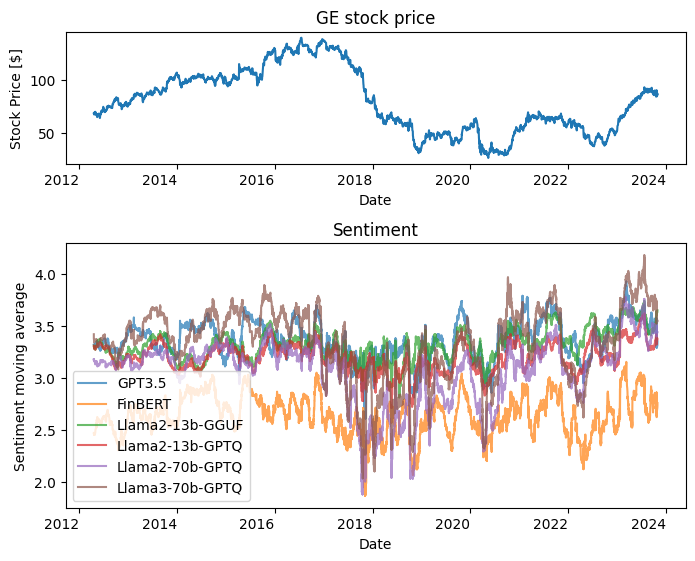

In [4]:
moving_average = merged_df.rolling(100).mean().dropna()

start_date = list(moving_average.index.get_level_values('Date'))[-1].to_pydatetime().replace(hour=0, minute=0)
end_date = list(moving_average.index.get_level_values('Date'))[0].to_pydatetime().replace(hour=0, minute=0) + datetime.timedelta(days = 1)
print(start_date, end_date)

stock_price = yf.Ticker('GE').history(start=start_date, end=end_date, period="1day", auto_adjust=False, actions=False)[['Adj Close']]

fig, ax = plt.subplots(2, 1, figsize=(8, 7), gridspec_kw={'height_ratios': [1, 2]})
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)


stock_price['Adj Close'].plot(ax=ax[0])
ax[0].set_ylabel('Stock Price [$]', fontsize=10)
ax[0].set_title('GE stock price')
ax[0].tick_params(axis='x', labelrotation=0)

moving_average.plot(ax=ax[1], alpha=0.7)
ax[1].set_ylabel('Sentiment moving average', fontsize=10)
ax[1].set_title('Sentiment')
ax[1].tick_params(axis='x', labelrotation=0)
# ax[1].set_xticks([])

plt.show()

In [6]:
stock_price

,Adj Close
Date,
2012-04-20 00:00:00-04:00,68.549629
2012-04-23 00:00:00-04:00,67.522827
2012-04-24 00:00:00-04:00,69.186966
2012-04-25 00:00:00-04:00,68.868286
2012-04-26 00:00:00-04:00,69.470253
...,...
2023-10-25 00:00:00-04:00,88.519753
2023-10-26 00:00:00-04:00,86.609253
2023-10-27 00:00:00-04:00,84.658951


Time stamps of GE are in GMT-4/-5 timezone

In [51]:
stock_price.index[0]

Timestamp('2012-04-20 00:00:00-0400', tz='America/New_York')

In [63]:
stock_price['Time'] = [date_extract(x) for x in stock_price.index]
print('Number of duplication in time: ', sum(stock_price['Time'].value_counts() >1))

Number of duplication in time:  0


In [64]:
stock_price.index = stock_price['Time']
stock_price.head()

,Adj Close,Time
Time,,
2012-04-20,68.549629,2012-04-20
2012-04-23,67.522827,2012-04-23
2012-04-24,69.186966,2012-04-24
2012-04-25,68.868286,2012-04-25
2012-04-26,69.470253,2012-04-26


#### Fama-French 3 factors

https://sec-api.io/resources/fama-french-factor-model

Retrieve FF3 so that timeframe matches sentiment data 

In [ ]:
print(start_date, end_date)

2012-04-20 00:00:00+00:00 2023-11-01 00:00:00+00:00


In [113]:
ff3 = pd.read_csv('../data/F-F_Research_Data_Factors_daily.csv', index_col=0).loc['20120420':'20231101']
ff3

,Mkt-RF,SMB,HML,RF
20120420,0.11,0.54,-0.10,0.000
20120423,-0.95,-0.56,0.15,0.000
20120424,0.29,0.26,0.91,0.000
20120425,1.44,0.40,-0.98,0.000
20120426,0.75,-0.02,-0.06,0.000
...,...,...,...,...
20231026,-1.15,0.85,1.66,0.021
20231027,-0.53,-0.35,-0.57,0.021
20231030,1.15,-0.39,0.28,0.021
20231031,0.63,0.05,-0.08,0.021


Convert 'ff3.index' so that it has the same format with sentiment data

In [116]:
new_ind = [datetime.datetime.strptime(x, '%Y%m%d').date() for x in ff3.index]
ff3.index = new_ind
ff3.index.name = 'Time'
ff3.head()

,Mkt-RF,SMB,HML,RF
Time,,,,
2012-04-20,0.11,0.54,-0.10,0.0
2012-04-23,-0.95,-0.56,0.15,0.0
2012-04-24,0.29,0.26,0.91,0.0
2012-04-25,1.44,0.40,-0.98,0.0
2012-04-26,0.75,-0.02,-0.06,0.0


#### Final full dataset
Combine sentiment data with factors and stock price

In [117]:
print(type(sent_daily.index[0]))
print(type(ff3.index[0]))
print(type(stock_price.index[0]))

<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>


In [118]:
df_full = pd.concat([sent_daily, ff3, stock_price],
                    axis=1, 
                    join='inner')
df_full

,GPT3.5,FinBERT,Llama2-13b-GGUF,Llama2-13b-GPTQ,Llama2-70b-GPTQ,Llama3-70b-GPTQ,Mkt-RF,SMB,HML,RF,Adj Close,Time
Time,,,,,,,,,,,,
2012-04-20,3.333333,2.935755,3.666667,3.666667,3.333333,4.666667,0.11,0.54,-0.10,0.000,68.549629,2012-04-20
2012-04-23,3.666667,2.869610,3.333333,3.333333,3.333333,3.666667,-0.95,-0.56,0.15,0.000,67.522827,2012-04-23
2012-04-24,4.000000,2.634394,4.000000,4.000000,3.000000,3.000000,0.29,0.26,0.91,0.000,69.186966,2012-04-24
2012-04-26,3.000000,0.777762,3.000000,3.000000,3.000000,3.000000,0.75,-0.02,-0.06,0.000,69.470253,2012-04-26
2012-04-30,3.000000,2.604599,4.000000,4.000000,4.000000,3.000000,-0.49,-0.57,0.00,0.000,69.328583,2012-04-30
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,4.666667,3.853571,3.666667,3.000000,2.333333,3.000000,-1.58,-0.30,0.84,0.021,88.519753,2023-10-25
2023-10-26,4.000000,2.274692,3.800000,3.400000,3.800000,4.200000,-1.15,0.85,1.66,0.021,86.609253,2023-10-26
2023-10-27,3.000000,1.883527,4.000000,3.666667,4.000000,4.333333,-0.53,-0.35,-0.57,0.021,84.658951,2023-10-27


#### Train-test split with purge

### Model